In [72]:
import os
import pandas as pd
from py2sambvca import p2s

In [2]:
METAL_ATOMS = ["Fe", "Ru", "Os", "Co", "Rh", "Ir", "Ni", "Pd", "Pt", "Cu", "Ag", "Au"]

In [23]:
file = "xyz/2-QIXFIM.xyz"
# file = "nhc.xyz"
with open(file, "r") as f:
    lines = f.readlines()[2:]
atoms = [line.split()[0] for line in lines]
metal_center = [i + 1 for i, atom in enumerate(atoms) if atom in METAL_ATOMS]
phosphorus = [i + 1 for i, atom in enumerate(atoms) if atom == "P"]
test_p2s = p2s(
    xyz_filepath=file,
    sphere_center_atom_ids=metal_center,
    z_ax_atom_ids=phosphorus,
    xz_plane_atoms_ids=[phosphorus[0]],
    atoms_to_delete_ids=metal_center,
    mesh_size=0.05,
    remove_H=0,
    verbose=2
)

In [47]:
output = test_p2s.run()

In [60]:
total_volume = output[0]["total_volume"]
percent_buried_volume = output[0]["percent_buried_volume"]
percent_buried_volume_sw = output[1]["percent_buried_volume"]["SW"]
percent_buried_volume_nw = output[1]["percent_buried_volume"]["NW"]
percent_buried_volume_se = output[1]["percent_buried_volume"]["SE"]
percent_buried_volume_ne = output[1]["percent_buried_volume"]["NE"]
dict = {"%Vbur": percent_buried_volume, "Total Volume": total_volume, "%Vbur SW": percent_buried_volume_sw, "%Vbur NW": percent_buried_volume_nw, "%Vbur SE": percent_buried_volume_se, "%Vbur NE": percent_buried_volume_ne}
pd.DataFrame(dict)

,%Vbur,Total Volume,%Vbur SW,%Vbur NW,%Vbur SE,%Vbur NE
0,42.7,179.5,48.7,38.3,37.9,45.9


In [68]:
xyz_list = []
xyz_files = [f for f in os.listdir("xyz")]
for xyz in xyz_files:
    name = xyz.strip(".xyz")
    xyz_path = "xyz/" + xyz
    with open(xyz_path, "r") as f:
        lines = f.readlines()[2:]
    atoms = [line.split()[0] for line in lines]
    metal_center = [i + 1 for i, atom in enumerate(atoms) if atom in METAL_ATOMS]
    phosphorus = [i + 1 for i, atom in enumerate(atoms) if atom == "P"]
    test_p2s = p2s(
        xyz_filepath=xyz_path,
        sphere_center_atom_ids=metal_center,
        z_ax_atom_ids=phosphorus,
        xz_plane_atoms_ids=[phosphorus[0]],
        atoms_to_delete_ids=metal_center,
        mesh_size=0.05,
        remove_H=0,
    )
    output = test_p2s.run()
    total_volume = output[0]["total_volume"]
    percent_buried_volume = output[0]["percent_buried_volume"]
    percent_buried_volume_sw = output[1]["percent_buried_volume"]["SW"]
    percent_buried_volume_nw = output[1]["percent_buried_volume"]["NW"]
    percent_buried_volume_se = output[1]["percent_buried_volume"]["SE"]
    percent_buried_volume_ne = output[1]["percent_buried_volume"]["NE"]
    
    xyz_list.append({"Name": name, "%Vbur": percent_buried_volume, "Total Volume": total_volume, "%Vbur SW": percent_buried_volume_sw, "%Vbur NW": percent_buried_volume_nw, "%Vbur SE": percent_buried_volume_se, "%Vbur NE": percent_buried_volume_ne})

sambvca_df = pd.DataFrame(xyz_list)
sambvca_df

,Name,%Vbur,Total Volume,%Vbur SW,%Vbur NW,%Vbur SE,%Vbur NE
0,10ent-PARMAY,49.5,179.5,48.6,46.5,51.5,51.4
1,19-EHERIT,46.2,179.5,52.0,45.6,45.4,41.9
2,19-FEHWAT,45.2,179.5,40.9,46.3,44.2,49.4
3,19-FEHWEX,45.5,179.5,41.0,46.3,45.1,49.7
4,19-FEHWIB,44.8,179.5,48.0,45.6,45.5,40.2
5,19-POKFAY,47.6,179.5,48.8,41.0,52.6,48.2
6,19-VUTGUO,47.8,179.5,39.9,49.2,50.7,51.4
7,19-WOCVIV,53.3,179.5,44.9,55.7,55.7,56.7
8,19-WOCVOB,51.1,179.5,54.2,42.4,55.7,52.0
9,19-WOCVUH,48.2,179.5,53.5,48.9,50.2,40.1


In [75]:
sambvca_df.to_excel("vbur_sambvca.xlsx", index=False)

[17:04:03] unsupported number of radical electrons 4


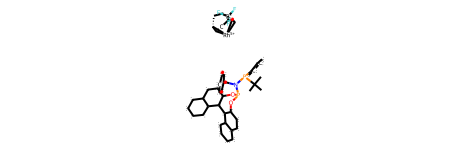

In [78]:
from rdkit import Chem

f1 = Chem.rdmolfiles.MolFromMol2File("RhCOD.mol2")
f2 = Chem.rdmolfiles.MolFromMol2File("AX1940.mol2")
Chem.CombineMols(f1, f2)